In [29]:
import os, sys
import numpy as np

import fitsio
import matplotlib.pyplot as plt

from astropy.table import Table, Column

import desimodel.io
from desimodel.focalplane import FocalPlane                                                                             
from desisim.scripts import quickgen
from desisim.io import get_tile_radec, write_simspec, read_simspec
from desispec.io.frame import read_frame
import desispec.io
from desispec import brick   

from desispec.log import get_logger
log = get_logger()

%matplotlib inline

In [39]:
def _default_wave(wavemin=None, wavemax=None, dw=0.2):
    '''Construct and return the default wavelength vector.'''

    if wavemin is None: 
        wavemin = desimodel.io.load_throughput('b').wavemin
    if wavemax is None:
        wavemax = desimodel.io.load_throughput('z').wavemax
    wave = np.arange(round(wavemin, 1), wavemax, dw)
                                                                                                              
    return wave

In [13]:
def get_lensing_targets(priors, tileid=None, seed=None, specmin=0):
    """
    Returns:
        fibermap
        truth table
    TODO: document this better
    
    """
    from desispec.io.fibermap import empty_fibermap
    from desisim.io import empty_metatable
    from desisim.templates import ELG, LRG

    if tileid is None:
        tile_ra, tile_dec = 0.0, 0.0
    else:
        tile_ra, tile_dec = get_tile_radec(tileid)  
    
    log.debug('Using random seed {}'.format(seed))
    rand = np.random.RandomState(seed)
    
    # Get DESI wavelength coverage.
    wave = _default_wave()
    nwave = len(wave)
    
    # Initialize the 'truth' dictionary and output metadata and fibermap tables.
    nspec = priors['NSPEC']
    truth = dict()
    truth['FLUX'] = np.zeros((nspec, len(wave)))
    truth['OBJTYPE'] = np.zeros(nspec, dtype=(str, 10))
    truth['WAVE'] = wave

    objtype = 'LRG'
    truth['META'] = empty_metatable(nmodel=nspec, objtype=objtype)
    truth['OBJTYPE'] = objtype

    fibermap = empty_fibermap(nspec)
    fibermap['OBJTYPE'] = objtype
    
    # Simulate spectra according to the input priors.
    elg = ELG(wave=wave)
    lrg = LRG(wave=wave)

    esimflux, _, emeta = elg.make_templates(nmodel=nspec, seed=seed, 
                                            zrange=priors['ZRANGE_SOURCE'],
                                            rmagrange=priors['MAGRANGE_SOURCE'],
                                            nocolorcuts=True, novdisp=True)
    lsimflux, _, lmeta = lrg.make_templates(nmodel=nspec, seed=seed,
                                            zrange=priors['ZRANGE_LENS'],
                                            zmagrange=priors['MAGRANGE_LENS'],
                                            nocolorcuts=True, novdisp=True)
    simflux = lsimflux + esimflux
    log.debug('This is wrong! Using the LRG table for META.')
    meta = lmeta 

    truth['FLUX'] = 1e17 * simflux
    truth['UNITS'] = '1e-17 erg/s/cm2/A'
    truth['META'] = meta
    truth['META_SOURCE'] = emeta

    ugrizy = 22.5-2.5*np.log10(meta['DECAM_FLUX'].data)
    wise = 22.5-2.5*np.log10(meta['WISE_FLUX'].data)
    fibermap['FILTER'][:, :6] = ['DECAM_G', 'DECAM_R', 'DECAM_Z', 'WISE_W1', 'WISE_W2']
    fibermap['MAG'][:, 0] = ugrizy[:, 1]
    fibermap['MAG'][:, 1] = ugrizy[:, 2]
    fibermap['MAG'][:, 2] = ugrizy[:, 4]
    fibermap['MAG'][:, 3] = wise[:, 0]
    fibermap['MAG'][:, 4] = wise[:, 1]

    # Load fiber -> positioner mapping and tile information
    fiberpos = desimodel.io.load_fiberpos()

    # Where are these targets?  Centered on positioners for now.
    x = fiberpos['X'][specmin:specmin+nspec]
    y = fiberpos['Y'][specmin:specmin+nspec]
    fp = FocalPlane(tile_ra, tile_dec)
    ra = np.zeros(nspec)
    dec = np.zeros(nspec)
    for i in range(nspec):
        ra[i], dec[i] = fp.xy2radec(x[i], y[i])

    # Fill in the rest of the fibermap structure
    fibermap['FIBER'] = np.arange(nspec, dtype='i4')
    fibermap['POSITIONER'] = fiberpos['POSITIONER'][specmin:specmin+nspec]
    fibermap['SPECTROID'] = fiberpos['SPECTROGRAPH'][specmin:specmin+nspec]
    fibermap['TARGETID'] = rand.randint(sys.maxsize, size=nspec)
    fibermap['TARGETCAT'] = np.zeros(nspec, dtype=(str, 20))
    fibermap['LAMBDAREF'] = np.ones(nspec, dtype=np.float32)*5400
    fibermap['RA_TARGET'] = ra
    fibermap['DEC_TARGET'] = dec
    fibermap['X_TARGET'] = x
    fibermap['Y_TARGET'] = y
    fibermap['X_FVCOBS'] = fibermap['X_TARGET']
    fibermap['Y_FVCOBS'] = fibermap['Y_TARGET']
    fibermap['X_FVCERR'] = np.zeros(nspec, dtype=np.float32)
    fibermap['Y_FVCERR'] = np.zeros(nspec, dtype=np.float32)
    fibermap['RA_OBS'] = fibermap['RA_TARGET']
    fibermap['DEC_OBS'] = fibermap['DEC_TARGET']
    fibermap['BRICKNAME'] = brick.brickname(ra, dec)

    return fibermap, truth

In [14]:
def new_lensing_exposure(priors, airmass=1.0, exptime=None, expid=None,
                         seed=None, lensingdir='./'):
    """
    Create a new exposure and output input simulation files.
    Does not generate pixel-level simulations or noisy spectra.

    Args:
        priors (astropy.Table): table of prior parameters

    Options:
        airmass : airmass, default 1.0
        exptime : exposure time in seconds
        seed : random seed
        lensingdir : output directory

    Writes:
        $LENSINGDIR/fibermap-{expid}.fits
        $LENSINGDIR/simspec-{expid}.fits

    Returns:
        fibermap numpy structured array
        truth dictionary

    Notes:

    """
    import time
    from desisim.obs import get_next_expid, get_next_tileid, get_night

    if expid is None:
        expid = get_next_expid()
    tileid = get_next_tileid()
    night = get_night(utc=time.gmtime()) # simulation obs time = now, even if sun is up
    dateobs = time.strptime(night+':22', '%Y%m%d:%H')
    
    flavor = 'science'
    
    params = desimodel.io.load_desiparams()
    if exptime is None:
        exptime = params['exptime']
        
    nspec = priors['NSPEC']
    log.debug('Generating {} targets'.format(nspec))
    fibermap, truth = get_lensing_targets(priors, tileid=tileid, seed=seed)

    flux = truth['FLUX']
    wave = truth['WAVE']
    nwave = len(wave)

    # Load sky [Magic knowledge of units 1e-17 erg/s/cm2/A/arcsec2]
    skyfile = os.getenv('DESIMODEL')+'/data/spectra/spec-sky.dat'

    log.info('skyfile {}'.format(skyfile))
    skywave, skyflux = np.loadtxt(skyfile, unpack=True)
    skyflux = np.interp(wave, skywave, skyflux)
    truth['SKYFLUX'] = skyflux

    log.debug('Calculating flux -> photons')
    for channel in ('B', 'R', 'Z'):
        thru = desimodel.io.load_throughput(channel)

        ii = np.where( (thru.wavemin <= wave) & (wave <= thru.wavemax) )[0]

        # Project flux to photons
        phot = thru.photons(wave[ii], flux[:,ii], units=truth['UNITS'],
                objtype='LRG', exptime=exptime, airmass=airmass)

        truth['PHOT_'+channel] = phot
        truth['WAVE_'+channel] = wave[ii]

        # Project sky flux to photons
        skyphot = thru.photons(wave[ii], skyflux[ii]*airmass,
                               units='1e-17 erg/s/cm2/A/arcsec2',
                               objtype='SKY', exptime=exptime, airmass=airmass)

        # 2D version
        ### truth['SKYPHOT_'+channel] = np.tile(skyphot, nspec).reshape((nspec, len(ii)))
        # 1D version
        truth['SKYPHOT_{}'.format(channel)] = skyphot.astype(np.float32)

    # NOTE: someday skyflux and skyphot may be 2D instead of 1D

    # Extract the metadata part of the truth dictionary into a table
    meta = truth['META']

    # Write fibermap
    telera, teledec = get_tile_radec(tileid)
    hdr = dict(
        NIGHT = (night, 'Night of observation YEARMMDD'),
        EXPID = (expid, 'DESI exposure ID'),
        TILEID = (tileid, 'DESI tile ID'),
        FLAVOR = (flavor, 'Flavor [arc, flat, science, ...]'),
        TELRA = (telera, 'Telescope pointing RA [degrees]'),
        TELDEC = (teledec, 'Telescope pointing dec [degrees]'),
        )
    #- ISO 8601 DATE-OBS year-mm-ddThh:mm:ss
    fiberfile = os.path.join(lensingdir, 'fibermap-{:08d}.fits'.format(expid))
    desispec.io.write_fibermap(fiberfile, fibermap, header=hdr)
    log.info('Wrote {}'.format(fiberfile))

    #- Write simspec; expand fibermap header
    hdr['AIRMASS'] = (airmass, 'Airmass at middle of exposure')
    hdr['EXPTIME'] = (exptime, 'Exposure time [sec]')
    hdr['DATE-OBS'] = (time.strftime('%FT%T', dateobs), 'Start of exposure')

    simfile = os.path.join(lensingdir, 'simspec-{:08d}.fits'.format(expid))
    _ = write_simspec(meta, truth, expid, night, header=hdr, outfile=simfile)
    log.info('Wrote {}'.format(simfile))

    return fibermap, truth

In [40]:
# Initialize the table of prior parameters.
outdir = os.path.join(os.getenv('HOME'), 'simlens')
print(outdir)

# Temporarily hack the DESI environments
os.environ['DESI_SPECTRO_DATA'] = outdir
os.environ['PIXPROD'] = './'

seed = 456
rand = np.random.RandomState(seed)

# Make our table.
nspec = 3
exptime = np.array([10000.0, 100000.0]).astype('f4')
nexp = len(exptime)
expid = np.arange(nexp)

priors = dict()
priors['EXPID'] = expid
priors['EXPTIME'] = exptime
priors['SEED'] = seed
priors['NSPEC'] = nspec
priors['ZRANGE_SOURCE'] = np.array([1.0, 1.0])
priors['ZRANGE_LENS'] = np.array([0.5, 0.5])
priors['MAGRANGE_SOURCE'] = np.array([21.0, 21.0])
priors['MAGRANGE_LENS'] = np.array([21.3, 21.3])
print(priors)

/home/desi1/simlens
{'MAGRANGE_SOURCE': array([ 21.,  21.]), 'EXPID': array([0, 1]), 'MAGRANGE_LENS': array([ 21.3,  21.3]), 'ZRANGE_LENS': array([ 0.5,  0.5]), 'NSPEC': 3, 'ZRANGE_SOURCE': array([ 1.,  1.]), 'SEED': 456, 'EXPTIME': array([  10000.,  100000.], dtype=float32)}


In [41]:
# Generate fibermap and simspec files.
for ii in range(nexp):
    fibermap, truth = new_lensing_exposure(priors, exptime=priors['EXPTIME'][ii], 
                                           expid=priors['EXPID'][ii], seed=seed, 
                                           lensingdir=outdir)
    # Write out truth table of the source.
    #source_meta = truth['META_SOURCE']


INFO:io.py:622:read_basis_templates: Reading /global/work/desi/spectro/templates/basis_templates/v2.2/elg_templates_v2.0.fits
INFO:io.py:622:read_basis_templates: Reading /global/work/desi/spectro/templates/basis_templates/v2.2/lrg_templates_v1.3.fits
INFO:<ipython-input-14-4fdd4a8140e2>:53:new_lensing_exposure: skyfile /usr/local/desihub/desimodel/data/spectra/spec-sky.dat
INFO:<ipython-input-14-4fdd4a8140e2>:99:new_lensing_exposure: Wrote /home/desi1/simlens/fibermap-00000000.fits
INFO:<ipython-input-14-4fdd4a8140e2>:108:new_lensing_exposure: Wrote /home/desi1/simlens/simspec-00000000.fits


INFO:io.py:622:read_basis_templates: Reading /global/work/desi/spectro/templates/basis_templates/v2.2/elg_templates_v2.0.fits
INFO:io.py:622:read_basis_templates: Reading /global/work/desi/spectro/templates/basis_templates/v2.2/lrg_templates_v1.3.fits
INFO:<ipython-input-14-4fdd4a8140e2>:53:new_lensing_exposure: skyfile /usr/local/desihub/desimodel/data/spectra/spec-sky.dat
INFO:<ipython-input-14-4fdd4a8140e2>:99:new_lensing_exposure: Wrote /home/desi1/simlens/fibermap-00000001.fits
INFO:<ipython-input-14-4fdd4a8140e2>:108:new_lensing_exposure: Wrote /home/desi1/simlens/simspec-00000001.fits


In [42]:
# Run quickgen
for ii in range(nexp):
    expid = priors['EXPID'][ii]
    fiberfile = 'fibermap-{:08d}.fits'.format(expid)
    #simfile = 'simspec-{:08d}.fits'.format(expid)
    #fiberfile = os.path.join(outdir, 'fibermap-{:08d}.fits'.format(expid))
    simfile = os.path.join(outdir, 'simspec-{:08d}.fits'.format(expid))
    print(fiberfile, simfile)
    quickargs = quickgen.parse(['--simspec', simfile, '--fibermap', fiberfile, '--outdir', outdir])
    quickgen.main(quickargs)


fibermap-00000000.fits /home/desi1/simlens/simspec-00000000.fits
INFO:quickgen.py:242:main: Reading fibermap file /home/desi1/simlens/fibermap-00000000.fits
INFO:quickgen.py:275:main: Initializing SpecSim with config desi
INFO:quickgen.py:281:main: Reading input file /home/desi1/simlens/simspec-00000000.fits
INFO:quickgen.py:310:main: Only 3 spectra in input file
HEY!!!!!!!!!!!!!!!!!!!!!!! LRG
HEY!!!!!!!!!!!!!!!!!!!!!!! LRG
HEY!!!!!!!!!!!!!!!!!!!!!!! LRG
INFO:quickgen.py:671:main: Writing files for channel:b, spectrograph:0, spectra:0 to 3
INFO:quickgen.py:697:main: Wrote file /home/desi1/simlens/frame-b0-00000000.fits
INFO:quickgen.py:714:main: Wrote file /home/desi1/simlens/cframe-b0-00000000.fits
INFO:quickgen.py:729:main: Wrote file /home/desi1/simlens/sky-b0-00000000.fits
INFO:quickgen.py:750:main: Wrote file /home/desi1/simlens/calib-b0-00000000.fits
INFO:quickgen.py:671:main: Writing files for channel:r, spectrograph:0, spectra:0 to 3
INFO:quickgen.py:697:main: Wrote file /home/

INFO:quickgen.py:714:main: Wrote file /home/desi1/simlens/cframe-r0-00000000.fits
INFO:quickgen.py:729:main: Wrote file /home/desi1/simlens/sky-r0-00000000.fits
INFO:quickgen.py:750:main: Wrote file /home/desi1/simlens/calib-r0-00000000.fits
INFO:quickgen.py:671:main: Writing files for channel:z, spectrograph:0, spectra:0 to 3
INFO:quickgen.py:697:main: Wrote file /home/desi1/simlens/frame-z0-00000000.fits
INFO:quickgen.py:714:main: Wrote file /home/desi1/simlens/cframe-z0-00000000.fits
INFO:quickgen.py:729:main: Wrote file /home/desi1/simlens/sky-z0-00000000.fits
INFO:quickgen.py:750:main: Wrote file /home/desi1/simlens/calib-z0-00000000.fits
fibermap-00000001.fits /home/desi1/simlens/simspec-00000001.fits
INFO:quickgen.py:242:main: Reading fibermap file /home/desi1/simlens/fibermap-00000001.fits
INFO:quickgen.py:275:main: Initializing SpecSim with config desi
INFO:quickgen.py:281:main: Reading input file /home/desi1/simlens/simspec-00000001.fits
INFO:quickgen.py:310:main: Only 3 spec

INFO:quickgen.py:714:main: Wrote file /home/desi1/simlens/cframe-r0-00000001.fits
INFO:quickgen.py:729:main: Wrote file /home/desi1/simlens/sky-r0-00000001.fits
INFO:quickgen.py:750:main: Wrote file /home/desi1/simlens/calib-r0-00000001.fits
INFO:quickgen.py:671:main: Writing files for channel:z, spectrograph:0, spectra:0 to 3
INFO:quickgen.py:697:main: Wrote file /home/desi1/simlens/frame-z0-00000001.fits
INFO:quickgen.py:714:main: Wrote file /home/desi1/simlens/cframe-z0-00000001.fits
INFO:quickgen.py:729:main: Wrote file /home/desi1/simlens/sky-z0-00000001.fits
INFO:quickgen.py:750:main: Wrote file /home/desi1/simlens/calib-z0-00000001.fits


In [43]:
# Read the simspec file to get trueflux.
simfile = os.path.join(outdir, 'simspec-{:08d}.fits'.format(0))
sim = read_simspec(simfile)

simfile1 = os.path.join(outdir, 'simspec-{:08d}.fits'.format(1))
sim1 = read_simspec(simfile1)

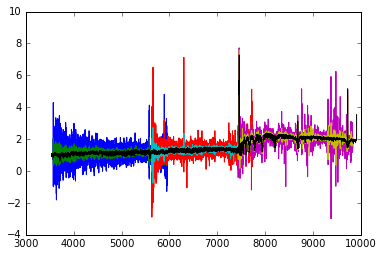

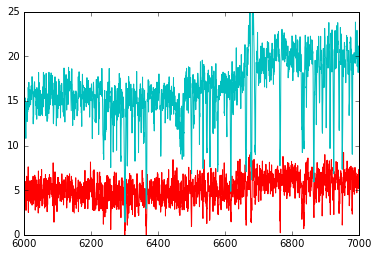

In [52]:
for channel in ('b', 'r', 'z'):
    ff = desispec.io.read_frame(os.path.join(outdir, 'cframe-{}0-{:08d}.fits'.format(channel, 0)))
    plt.plot(ff.wave, ff.flux[0, :])
    
    ff_test = desispec.io.read_frame(os.path.join(outdir, 'cframe-{}0-{:08d}.fits'.format(channel, 1)))
    plt.plot(ff_test.wave, ff_test.flux[0, :])

plt.plot(sim.wave['brz'], sim.flux[0, :], color='k')
plt.ylim(-4, 10)    
plt.show()

for channel in ('b', 'r', 'z'):
    ff = desispec.io.read_frame(os.path.join(outdir, 'cframe-{}0-{:08d}.fits'.format(channel, 0)))
    ff_test = desispec.io.read_frame(os.path.join(outdir, 'cframe-{}0-{:08d}.fits'.format(channel, 1)))
    plt.plot(ff.wave, ff.flux[0, :] * np.sqrt(ff.ivar[0, :]))
    plt.plot(ff_test.wave, ff_test.flux[0, :] * np.sqrt(ff_test.ivar[0, :]))
plt.xlim(6000, 7000)
plt.ylim(0, 25)
plt.show()

